In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

In [2]:
# Creating Engine

database_path="data/wildfires.sqlite"
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()


In [3]:
# Query All Records in the the Database
data = pd.read_sql("SELECT * FROM wildfirecleaned", conn)

In [4]:
data.head()


,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CAUSE_DESCR,CONT_DOY,FIRE_SIZE,FIRE_CLASS,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE,TOTAL DAYS
0,Plumas National Forest,2005,33,Miscellaneous,33.0,0.10,A,40.036944,-121.005833,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02 00:00:00,2005-02-02 00:00:00,0.0
1,Eldorado National Forest,2004,133,Lightning,133.0,0.25,A,38.933056,-120.404444,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12 00:00:00,2004-05-12 00:00:00,0.0
2,Eldorado National Forest,2004,152,Debris Burning,152.0,0.10,A,38.984167,-120.735556,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31 00:00:00,2004-05-31 00:00:00,0.0
3,Eldorado National Forest,2004,180,Lightning,185.0,0.10,A,38.559167,-119.913333,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28 00:00:00,2004-07-03 00:00:00,5.0
4,Eldorado National Forest,2004,180,Lightning,185.0,0.10,A,38.559167,-119.933056,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28 00:00:00,2004-07-03 00:00:00,5.0


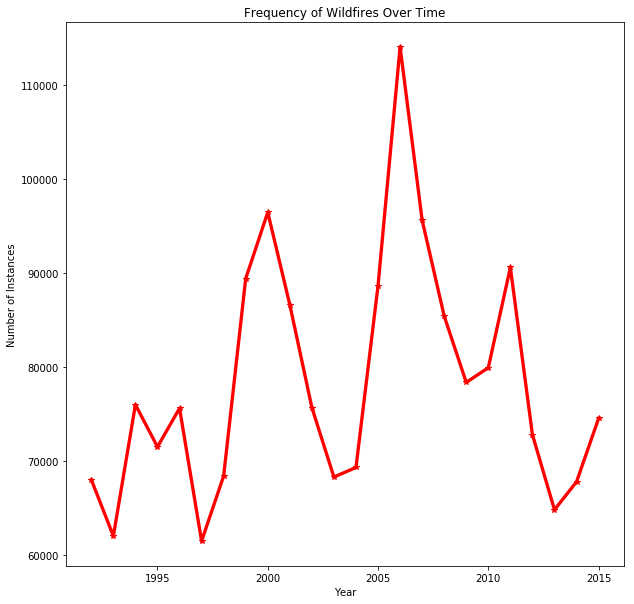

In [5]:
df_year = data[['FIRE_YEAR']]
df_year['FIRE_YEAR'].value_counts(sort=False).plot(kind="line",marker='*',figsize=(10,10), color='r', linewidth=3.3)
plt.title('Frequency of Wildfires Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Instances')
plt.show()

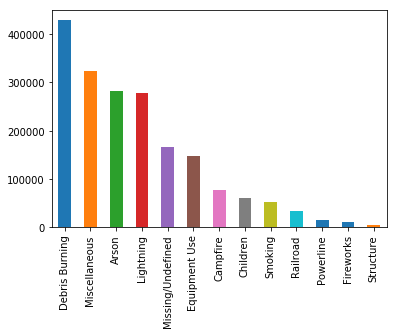

In [6]:
data["CAUSE_DESCR"].value_counts().plot(kind="bar")

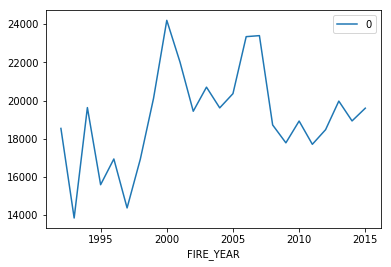

In [7]:
size_per_year=data.groupby(['FIRE_YEAR','FIRE_SIZE']).size().reset_index().groupby('FIRE_YEAR')[[0]].max()
size_per_year.plot()